## Classifica a qualidade do ar

- Esse projeto recebe os dados relativos a substâncias contidas no ar que são coletadas através de sensores químicos de qualidade do ar.
- Analisa e trata os dados submetendo a um algoritmo de clusterização de machine learning, definindo e marcando cada linha do arquivo com seu cluster mais adequado.
- Após a clusterização treina um modelo de classificação, em regressão logística de machine learning, fazendo a predição, em percentual, de qual a probabiliade da qualidade do ar, apresentado através dos componentes contidos no mesmo, de pertencer a um grupo ou a outro.

- Dados da qualidade do ar: https://archive.ics.uci.edu/dataset/360/air+quality

O conjunto de dados contém 9358 instâncias de respostas médias horárias de uma matriz de 5 sensores químicos de óxido de metal incorporados em um dispositivo multissensor químico de qualidade do ar. O dispositivo estava localizado no campo em uma área significativamente poluída, no nível da estrada, dentro de uma cidade italiana. Os dados foram registrados de março de 2004 a fevereiro de 2005 (um ano), representando as gravações mais longas disponíveis gratuitamente de respostas de dispositivos de sensores químicos de qualidade do ar implantados em campo. Concentrações médias horárias do Ground Truth para CO, hidrocarbonetos não metânicos, benzeno, óxidos de nitrogênio totais (NOx) e dióxido de nitrogênio (NO2) foram fornecidas por um analisador certificado de referência co-localizado. Evidências de sensibilidades cruzadas, bem como desvios de conceito e sensor estão presentes, conforme descrito em De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citação necessária), eventualmente afetando as capacidades de estimativa de concentração dos sensores. Valores ausentes são marcados com valor -200. Este conjunto de dados pode ser usado exclusivamente para fins de pesquisa. Fins comerciais são totalmente excluídos.



In [90]:
# importando bibliotecas
from sklearn.preprocessing import (
    OneHotEncoder, # transforma dados categóricos em colunas e valores binário 0-1
    StandardScaler, # faz a padronização dos dados para melhorar a normalidade
    MinMaxScaler, # transforma os valores dentro de uma escala entre 0 e 1 e melhora a normalidade
    PowerTransformer, # transforma os valores para melhorar a normalidade
)
from sklearn.compose import ColumnTransformer

from scipy.stats import skew 
from scipy.stats import kurtosis 
from fc import fc_retira_outliers as rto

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import warnings
warnings.simplefilter('ignore')

In [91]:
# carregando arquivo de dados da qualidade do ar
df_quality = pd.read_csv('arquivos/AirQualityUCI.csv', sep=';')

In [92]:
# verificando o tamanho do arquivo conferindo a quantidade de linhas(registros) e colunas(varáveis)
df_quality.shape

(9471, 17)

In [93]:
# reconhecendo as variáveis disponíveis
df_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


Verificamos que até a coluna 14 não existe nenhuma linha com nulos e que existem alguns campos que precisam ser removidos, por exemplo os 2 últimos serão eliminados do dataframe por possuirem somente valores nulos, vamos analisar mais a fundo cada um deles verificando a necessidade de modificar o tipo de dados.

In [94]:
# verificando as primeiras linhas do dataframe
df_quality.head(3)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN


As duas últimas colunas, como já mencionado, possuem valores nulos e serão eliminadas do dataframe, as demais colunas apresentam dados de data, hora e valores numéricos.

In [95]:
# vamos substituir vírgulas por pontos nos campos numéricos como separador decimal usado pelo python
# vamos retirar também algums espaços que existem entre os valores
df_quality['CO(GT)'] = df_quality['CO(GT)'].replace(',','.', regex=True)
df_quality['C6H6(GT)'] = df_quality['C6H6(GT)'].replace(',','.', regex=True)
df_quality['T'] = df_quality['T'].replace(',','.', regex=True)
df_quality['RH'] = df_quality['RH'].replace(',','.', regex=True)
df_quality['AH'] = df_quality['AH'].replace(',','.', regex=True)

df_quality['CO(GT)'] = df_quality['CO(GT)'].replace(' ','', regex=True)
df_quality['C6H6(GT)'] = df_quality['C6H6(GT)'].replace(' ','', regex=True)
df_quality['T'] = df_quality['T'].replace(' ','', regex=True)
df_quality['RH'] = df_quality['RH'].replace(' ','', regex=True)
df_quality['AH'] = df_quality['AH'].replace(' ','', regex=True)

df_quality['Date'] = df_quality['Date'].replace(' ','', regex=True)
df_quality['Time'] = df_quality['Time'].replace(' ','', regex=True)

In [96]:
# vamos modificar o tipo de dados de alguns campos conforme o conteúdo de informação contido nos mesmos
df_quality['Date'] = df_quality['Date'].astype('datetime64[ns]')
df_quality['CO(GT)'] = df_quality['CO(GT)'].astype(float)
df_quality['C6H6(GT)'] = df_quality['C6H6(GT)'].astype(float)
df_quality['T'] = df_quality['T'].astype(float)
df_quality['RH'] = df_quality['RH'].astype(float)
df_quality['AH'] = df_quality['AH'].astype(float)

Modificamos os campo Date para datetime pois vamos obter o dia da semana desses dados, os demais campos numéricos ficarão com o tipo float

In [97]:
# verificando como ficaram os tipos de dados
df_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         9357 non-null   float64       
 3   PT08.S1(CO)    9357 non-null   float64       
 4   NMHC(GT)       9357 non-null   float64       
 5   C6H6(GT)       9357 non-null   float64       
 6   PT08.S2(NMHC)  9357 non-null   float64       
 7   NOx(GT)        9357 non-null   float64       
 8   PT08.S3(NOx)   9357 non-null   float64       
 9   NO2(GT)        9357 non-null   float64       
 10  PT08.S4(NO2)   9357 non-null   float64       
 11  PT08.S5(O3)    9357 non-null   float64       
 12  T              9357 non-null   float64       
 13  RH             9357 non-null   float64       
 14  AH             9357 non-null   float64       
 15  Unnamed: 15    0 non-

In [98]:
# criando a coluna dia_semana através do campo de data (Date)
df_quality['dia_semana'] = df_quality['Date'].dt.day_of_week # 0 = segunda-feira

In [99]:
# exibindo a lista de colunas do dataframe
list(df_quality.columns)

['Date',
 'Time',
 'CO(GT)',
 'PT08.S1(CO)',
 'NMHC(GT)',
 'C6H6(GT)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'RH',
 'AH',
 'Unnamed: 15',
 'Unnamed: 16',
 'dia_semana']

In [100]:
# selecionando somente colunas de interesse do dataframe
df_quality = df_quality[['Date',
 'Time',
 'CO(GT)',
 'PT08.S1(CO)',
 'NMHC(GT)',
 'C6H6(GT)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'RH',
 'AH',
 'dia_semana']]

In [101]:
# criando lista com novos nomes para as colunas do dataframe
lista_nome = ['Date',
 'Time',
 'CO-mg/m3/hr',
 'CO/hr',
 'NMHC-micgr/m3/hr',
 'C6H6-micgr/m3/hr',
 'NMHC/hr',
 'NOx-ppb/hr',
 'NOx/hr',
 'NO2-micgr/m3/hr',
 'NO2/hr',
 'O3/hr',
 'temperatura°C',
 'umidade_relativa',
 'umidade_absoluta',
 'dia_semana']

In [102]:
# modificando o nome das colunas do dataframe
df_quality.columns = lista_nome

In [103]:
# verificando os novos nomes das colunas
df_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              9357 non-null   datetime64[ns]
 1   Time              9357 non-null   object        
 2   CO-mg/m3/hr       9357 non-null   float64       
 3   CO/hr             9357 non-null   float64       
 4   NMHC-micgr/m3/hr  9357 non-null   float64       
 5   C6H6-micgr/m3/hr  9357 non-null   float64       
 6   NMHC/hr           9357 non-null   float64       
 7   NOx-ppb/hr        9357 non-null   float64       
 8   NOx/hr            9357 non-null   float64       
 9   NO2-micgr/m3/hr   9357 non-null   float64       
 10  NO2/hr            9357 non-null   float64       
 11  O3/hr             9357 non-null   float64       
 12  temperatura°C     9357 non-null   float64       
 13  umidade_relativa  9357 non-null   float64       
 14  umidade_absoluta  9357 n

In [104]:
# verificando e confirmando se existe algum campo nulo no dataframe
df_quality.isnull().sum()

Date                114
Time                114
CO-mg/m3/hr         114
CO/hr               114
NMHC-micgr/m3/hr    114
C6H6-micgr/m3/hr    114
NMHC/hr             114
NOx-ppb/hr          114
NOx/hr              114
NO2-micgr/m3/hr     114
NO2/hr              114
O3/hr               114
temperatura°C       114
umidade_relativa    114
umidade_absoluta    114
dia_semana          114
dtype: int64

Mesmo que não tenha aparecido nenhum nulo utilizando a função .info() faz-se necessário confirmar se realmente não tem nulos e fizemos isso com a função .isnull().sum() somando as ocorrências de valores nulos que existem no dataframe.

In [105]:
# apagando todas as linhas que possuem valores nulos
df_quality = df_quality.dropna()

Nesse caso apagamos as linhas, com nulos, pois todas as colunas apresentaram campos nulos em algum momento.

In [106]:
# verificando a duplicidade de alguma linha
df_quality.duplicated().sum()

0

A existência de duplicidade pode comprometer os resultados quando treinarmos os modelos de machine learning, além de consumir recursos computacionais desnecessariamente, dessa excluiremos as linhas duplicadas, deixando somente uma ocorrência de cada linha. Nesse caso a soma de linhas duplicadas foi zero.

In [107]:
# apagando linhas duplicadas
#df_quality = df_quality.drop_duplicates()

In [108]:
# retirando os pontos dos valores da hora.minutos.segundos
def retira_pontos(time):
    time = time.replace('.', '')
    return time

In [109]:
# chamando a função para retirar os pontos da hora
# convertendo a hora em nro inteiro, divide por 10000 para saparar somente o valor da hora
# cria a coluna de horas (hour)
df_quality['hour'] = df_quality['Time'].apply(retira_pontos)
df_quality['hour'] = df_quality['hour'].astype(int)/10000

In [110]:
# apaga as colunas de data e hora (Date e Time)
df_quality = df_quality.drop('Date', axis=1)
df_quality = df_quality.drop('Time', axis=1)

In [111]:
# verificando as primeiras linhas com as novas colunas
df_quality.head(3)

,CO-mg/m3/hr,CO/hr,NMHC-micgr/m3/hr,C6H6-micgr/m3/hr,NMHC/hr,NOx-ppb/hr,NOx/hr,NO2-micgr/m3/hr,NO2/hr,O3/hr,temperatura°C,umidade_relativa,umidade_absoluta,dia_semana,hour
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,6.0,18.0
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,6.0,19.0
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,6.0,20.0


In [112]:
# verificando com quantas linhas e colunas ficou o dataframe
df_quality.shape

(9357, 15)

In [113]:
# chama função para retirar outliers, vamos passar mais de uma vez para reduzir os outliers
'''
i=0
while i != dfx.shape:
    i= dfx.shape
    dfx = rto.retira_outliers(dfx)
'''   

df_quality = rto.retira_outliers(df_quality)
df_quality = rto.retira_outliers(df_quality)
df_quality = rto.retira_outliers(df_quality)
df_quality = rto.retira_outliers(df_quality)
df_quality = rto.retira_outliers(df_quality)
df_quality = rto.retira_outliers(df_quality)

In [114]:
# verificando quantas linhas restaram após retirarmos os outliers
df_quality.shape

(5322, 15)

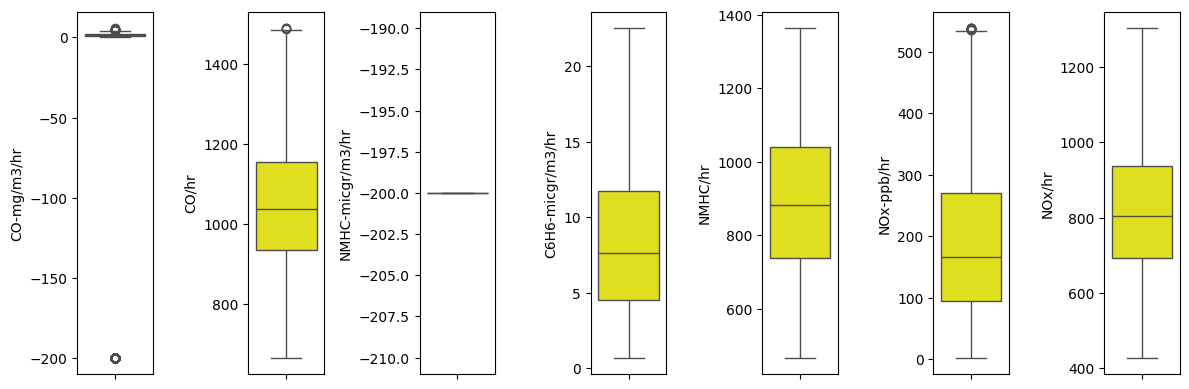

In [115]:
# visualizando boxplot para ver a distribuição nos quartis e a existência de outliers
# os outliers que sobraram não apresentam muita distorção, vamos mantê-los para não diminuir muito nossa
# base de dados
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(12, 4), tight_layout=True)

search_outliers = ['CO-mg/m3/hr',
                    'CO/hr',
                    'NMHC-micgr/m3/hr',
                    'C6H6-micgr/m3/hr',
                    'NMHC/hr',
                    'NOx-ppb/hr',
                    'NOx/hr',
               ]

for i, column in enumerate(search_outliers):
    sns.boxplot(y=column, data=df_quality, ax=axs[i], color='yellow')
plt.show()

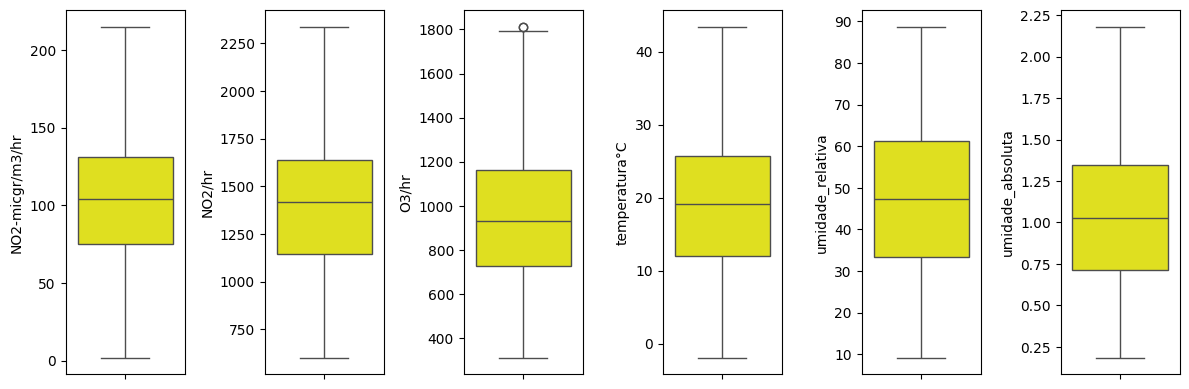

In [116]:
# visualizando boxplot para ver a distribuição nos quartis e a existência de outliers
# os outliers que sobraram não apresentam muita distorção, vamos mantê-los para não diminuir muito nossa
# base de dados
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(12, 4), tight_layout=True)

search_outliers = ['NO2-micgr/m3/hr',
                    'NO2/hr',
                    'O3/hr',
                    'temperatura°C',
                    'umidade_relativa',
                    'umidade_absoluta',
               ]

for i, column in enumerate(search_outliers):
    sns.boxplot(y=column, data=df_quality, ax=axs[i], color='yellow')
plt.show()

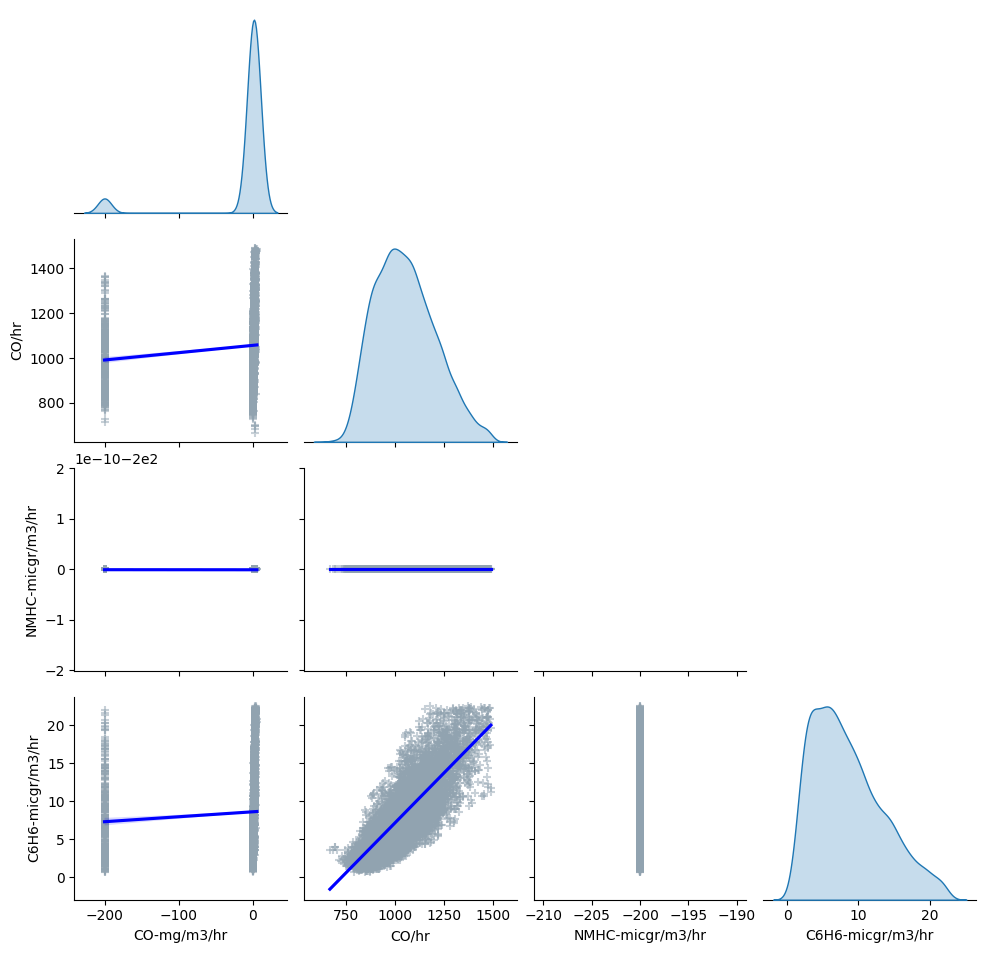

In [117]:
# verificando a distribuição dos dados
p= sns.pairplot(
   df_quality[['CO-mg/m3/hr',
               'CO/hr',
               'NMHC-micgr/m3/hr',
               'C6H6-micgr/m3/hr',
               ]],
                diag_kind="kde", corner=True, markers="+",
                plot_kws={'line_kws':{'color':'#0000ff'}, 
                           'scatter_kws': {'alpha': 0.5, 
                                           'color': '#91a3b0'}},
                kind='reg'
                );
p.fig.subplots_adjust(top=0.95)

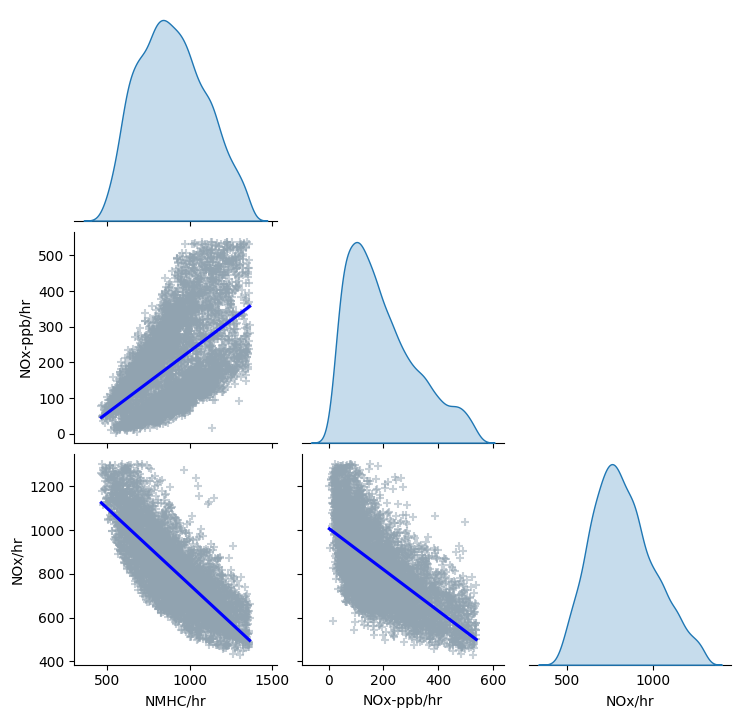

In [118]:
# verificando a distribuição dos dados
p= sns.pairplot(
   df_quality[['NMHC/hr',
               'NOx-ppb/hr',
               'NOx/hr',
               ]],
                diag_kind="kde", corner=True, markers="+",
                plot_kws={'line_kws':{'color':'#0000ff'}, 
                           'scatter_kws': {'alpha': 0.5, 
                                           'color': '#91a3b0'}},
                kind='reg'
                );
p.fig.subplots_adjust(top=0.95)

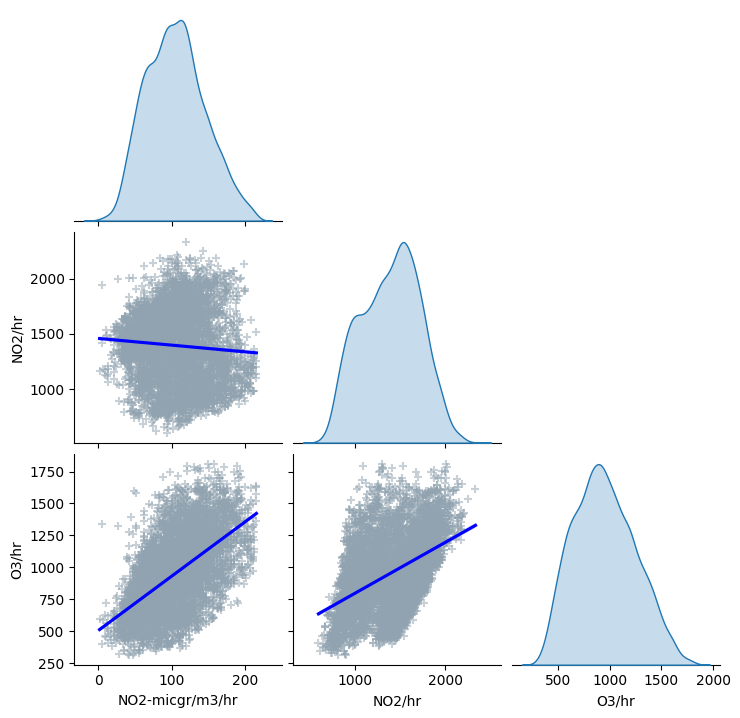

In [119]:
# verificando a distribuição dos dados
p= sns.pairplot(
   df_quality[['NO2-micgr/m3/hr',
               'NO2/hr',
               'O3/hr',
               ]],
                diag_kind="kde", corner=True, markers="+",
                plot_kws={'line_kws':{'color':'#0000ff'}, 
                           'scatter_kws': {'alpha': 0.5, 
                                           'color': '#91a3b0'}},
                kind='reg'
                );
p.fig.subplots_adjust(top=0.95)

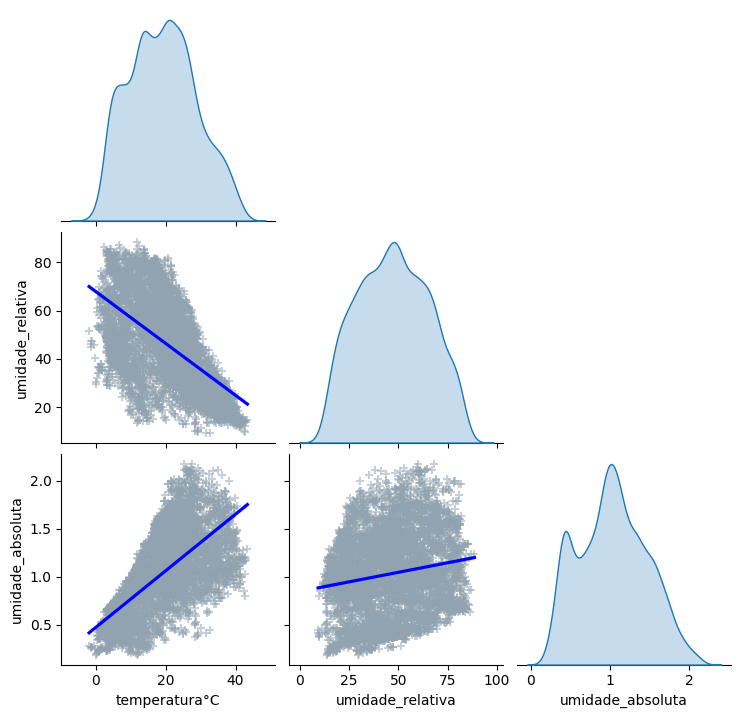

In [120]:
# verificando a distribuição dos dados
p= sns.pairplot(
   df_quality[['temperatura°C',
               'umidade_relativa',
               'umidade_absoluta'
               ]],
                diag_kind="kde", corner=True, markers="+",
                plot_kws={'line_kws':{'color':'#0000ff'}, 
                           'scatter_kws': {'alpha': 0.5, 
                                           'color': '#91a3b0'}},
                kind='reg'
                );
p.fig.subplots_adjust(top=0.95)

In [121]:
# verificando os valores da skew e kurtosis
# os valores aceitos tanto para skew quanto para kurtosis devem variar entre -2 e 2
# gerando um dataframe com os valores de skew e kurtosis para analisarmos melhor
df_skew_kurtosis_og = pd.DataFrame()
df_skew_kurtosis_og['variavel'] = 'Nan'
df_skew_kurtosis_og['skew'] = 'Nan'
df_skew_kurtosis_og['kurtosis'] = 'Nan'

for variavel in list(df_quality.columns):
    skewx = skew(df_quality[variavel], axis=0, bias=True)
    kurtx = kurtosis(df_quality[variavel], axis=0, bias=True)

    dfx = {'variavel': [variavel], 'skew': [skewx], 'kurtosis': [kurtx]}
    dfx = pd.DataFrame(dfx)
    df_skew_kurtosis_og = pd.concat([df_skew_kurtosis_og, dfx], axis=0)    

    print('skew ' + variavel, skewx)
    print('kurtosis ' + variavel, kurtx)
    print('')   

skew CO-mg/m3/hr -3.38900211829423
kurtosis CO-mg/m3/hr 9.48996734651026

skew CO/hr 0.4041805614171279
kurtosis CO/hr -0.3570607875812768

skew NMHC-micgr/m3/hr nan
kurtosis NMHC-micgr/m3/hr nan

skew C6H6-micgr/m3/hr 0.6818921822509197
kurtosis C6H6-micgr/m3/hr -0.25806948569862964

skew NMHC/hr 0.21438099643182865
kurtosis NMHC/hr -0.7080889241939858

skew NOx-ppb/hr 0.7909878323167558
kurtosis NOx-ppb/hr -0.18133820817073198

skew NOx/hr 0.4049862180812227
kurtosis NOx/hr -0.3594054214532245

skew NO2-micgr/m3/hr 0.25521853853391435
kurtosis NO2-micgr/m3/hr -0.4103675095283008

skew NO2/hr -0.07092504926047183
kurtosis NO2/hr -0.7568112196255594

skew O3/hr 0.2674895091204829
kurtosis O3/hr -0.5434223586388973

skew temperatura°C 0.18760438616765085
kurtosis temperatura°C -0.683060805838144

skew umidade_relativa 0.050455630739940874
kurtosis umidade_relativa -0.8884729450276461

skew umidade_absoluta 0.1481804325882072
kurtosis umidade_absoluta -0.7006686509630793

skew dia_semana

In [122]:
# preenchendo os valore nulos com zero
# resetando o indice
df_skew_kurtosis_og = df_skew_kurtosis_og.fillna(0)
df_skew_kurtosis_og = df_skew_kurtosis_og.reset_index()
df_skew_kurtosis_og = df_skew_kurtosis_og.drop('index', axis=1)
print(df_skew_kurtosis_og)

            variavel      skew  kurtosis
0        CO-mg/m3/hr -3.389002  9.489967
1              CO/hr  0.404181 -0.357061
2   NMHC-micgr/m3/hr  0.000000  0.000000
3   C6H6-micgr/m3/hr  0.681892 -0.258069
4            NMHC/hr  0.214381 -0.708089
5         NOx-ppb/hr  0.790988 -0.181338
6             NOx/hr  0.404986 -0.359405
7    NO2-micgr/m3/hr  0.255219 -0.410368
8             NO2/hr -0.070925 -0.756811
9              O3/hr  0.267490 -0.543422
10     temperatura°C  0.187604 -0.683061
11  umidade_relativa  0.050456 -0.888473
12  umidade_absoluta  0.148180 -0.700669
13        dia_semana -0.052699 -1.303217
14              hour -0.044007 -1.168320


In [123]:
# incluindo colunas de valores minimos e máximos para skew e kurtosis que aparecerão no gráfico
df_skew_kurtosis_og['max'] = 2
df_skew_kurtosis_og['min'] = -2

<Axes: title={'center': 'Categorias Agrupadas por Cluster - vrs originais'}, xlabel='variavel'>

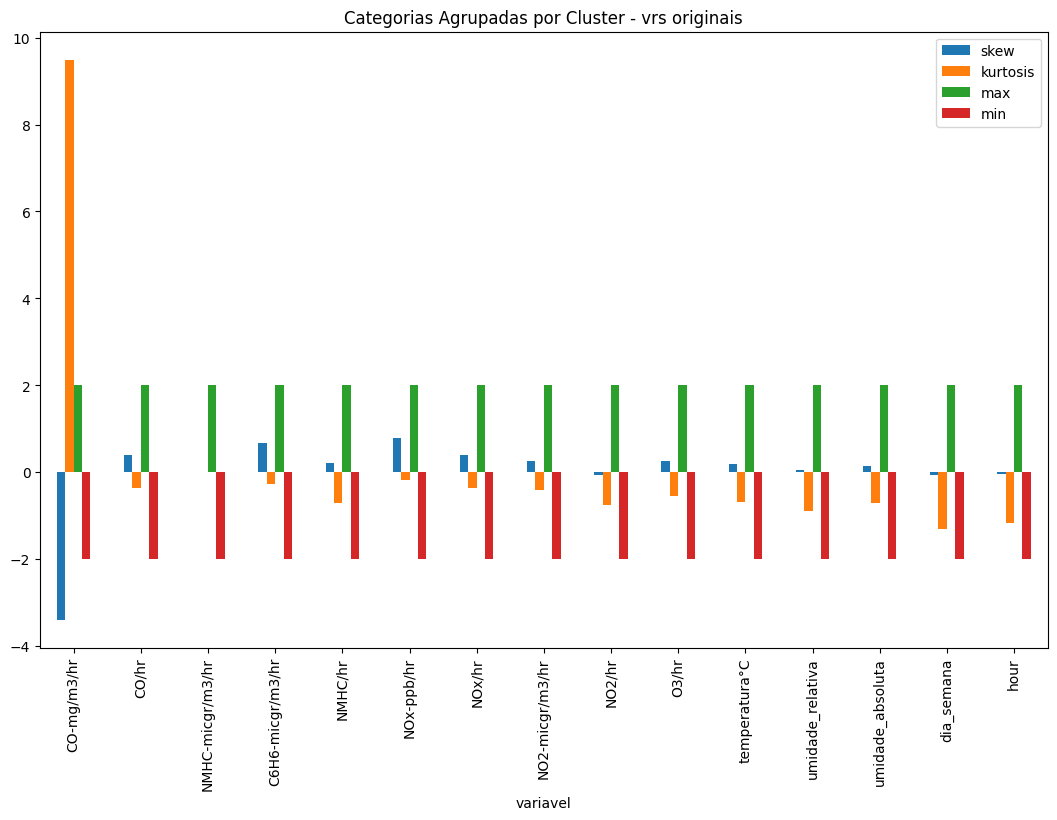

In [124]:
# plotando um gráfico para analisarmos os valores de skew e kurtosis
df_skew_kurtosis_og.plot(x='variavel', 
        kind='bar', 
        stacked=False, 
        title='Categorias Agrupadas por Cluster - vrs originais',
        figsize=(13,8))

Observamos que a maioria das variáveis ficaram com os valores dentro do máximo e mínimo de skew e kurtosis, sendo que somente CO-mg/m3/hr e NMHC-micgr/m3/hr serão excluídas, a primeira ficou fora do min e max e a segunda apresentou nulos quando do cálculo de skew e kurtosis tendo seus valores substituidos por zero para geração do gráfico. As variáveis dia_semana e hour não serão consideradas em relação a skew e kurtosis pois são variáveis categóricas e serão transformadas em binárias para cada um de seus valores.

In [125]:
# fazendo um sorte pelo valor do skew no dataframe
df_skew_kurtosis_og = df_skew_kurtosis_og.sort_values('skew', ascending=True)

In [126]:
# verificando as colunas incluidas no dataframe
df_skew_kurtosis_og.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 0 to 5
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variavel  15 non-null     object 
 1   skew      15 non-null     float64
 2   kurtosis  15 non-null     float64
 3   max       15 non-null     int64  
 4   min       15 non-null     int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 720.0+ bytes


In [127]:
# apagando as colunas que tiveram problemas com skew e kurtosis
df_quality = df_quality.drop('CO-mg/m3/hr', axis=1)
df_quality = df_quality.drop('NMHC-micgr/m3/hr', axis=1)

In [128]:
# verificando o nro de ocorrências para cada dia da semana
df_quality['dia_semana'].value_counts()

dia_semana
0.0    850
6.0    845
5.0    796
4.0    732
3.0    730
2.0    685
1.0    684
Name: count, dtype: int64

In [129]:
# verificando o nro de ocorrências para cada valor da hora
df_quality['hour'].value_counts()

hour
23.0    263
1.0     262
0.0     258
15.0    256
22.0    254
6.0     254
14.0    249
2.0     249
13.0    247
12.0    247
5.0     245
7.0     244
16.0    241
4.0     237
21.0    228
17.0    224
11.0    223
10.0    203
20.0    202
18.0    191
9.0     186
19.0    177
8.0     156
3.0      26
Name: count, dtype: int64

In [130]:
# eliminando as linhas com hora = 3 por apresentar um baixo nro de ocorrências em relação às outras horas
df_quality = df_quality[df_quality.hour != 3]

In [131]:
# verificando quantas linhas e colunas restaram no novo dataframe
df_quality.shape

(5296, 13)

In [132]:
# resetando o índice do dataframe
df_quality = df_quality.reset_index()

In [133]:
# excluindo a coluna index gerada pelo reset
df_quality = df_quality.drop('index', axis=1)

In [134]:
# verificando o índice das primeiras linhas após o reset
df_quality.head(5)

,CO/hr,C6H6-micgr/m3/hr,NMHC/hr,NOx-ppb/hr,NOx/hr,NO2-micgr/m3/hr,NO2/hr,O3/hr,temperatura°C,umidade_relativa,umidade_absoluta,dia_semana,hour
0,1473.0,14.3,1127.0,224.0,831.0,152.0,1752.0,1568.0,20.8,34.4,0.8365,3.0,11.0
1,1379.0,12.5,1068.0,171.0,899.0,139.0,1663.0,1374.0,23.8,28.2,0.8219,3.0,12.0
2,1385.0,12.2,1056.0,149.0,891.0,133.0,1648.0,1268.0,24.2,28.7,0.8515,3.0,13.0
3,1379.0,13.1,1087.0,137.0,901.0,126.0,1660.0,1144.0,25.2,24.9,0.7829,3.0,14.0
4,1322.0,14.4,1129.0,149.0,934.0,128.0,1639.0,1109.0,27.0,17.8,0.6275,3.0,15.0


In [135]:
# criando as listas de colunas numéricas que serão transformadas e categorizadas
colunas_nro = [
 'CO/hr',
 'C6H6-micgr/m3/hr',
 'NMHC/hr',
 'NOx-ppb/hr',
 'NOx/hr',
 'NO2-micgr/m3/hr',
 'NO2/hr',
 'O3/hr',
 'temperatura°C',
 'umidade_relativa',
 'umidade_absoluta',
 ]

colunas_onehot = [
 'dia_semana',
 'hour',
 ]

In [136]:
# definindo uma instância do columnTransformer para fazer uma verificação de transformação de variáveis
preprocessing = ColumnTransformer(
    [
        ("one-hot", OneHotEncoder(), colunas_onehot),
        #("standard", StandardScaler(), colunas_nro),
        ("minmax", MinMaxScaler(), colunas_nro),
        #("power", PowerTransformer(), colunas_nro),
    ]
)

preprocessing.fit_transform(df_quality)

array([[0.        , 0.        , 0.        , ..., 0.50110375, 0.31698113,
        0.32656947],
       [0.        , 0.        , 0.        , ..., 0.56732892, 0.23899371,
        0.31925447],
       [0.        , 0.        , 0.        , ..., 0.57615894, 0.24528302,
        0.33408487],
       ...,
       [1.        , 0.        , 0.        , ..., 0.63576159, 0.11446541,
        0.22841826],
       [1.        , 0.        , 0.        , ..., 0.66666667, 0.05408805,
        0.16493812],
       [1.        , 0.        , 0.        , ..., 0.67108168, 0.0490566 ,
        0.15937672]])

In [137]:
# fazendo a transformação de variáveis com fit_transform e convertendo para um dataframe
df_quality_trans = pd.DataFrame(
    preprocessing.fit_transform(df_quality),
    columns=preprocessing.get_feature_names_out(), 
)

---

In [138]:
# juntando o dataframe original dos dados categóricos com o dataframe gerado com variáveis transformadas
df_quality_trans = pd.concat([df_quality, df_quality_trans], axis=1)

In [139]:
# verificando os dados das primeiras linhas dos dois dataframes juntados
df_quality_trans.head(3)

,CO/hr,C6H6-micgr/m3/hr,NMHC/hr,NOx-ppb/hr,NOx/hr,NO2-micgr/m3/hr,NO2/hr,O3/hr,temperatura°C,umidade_relativa,umidade_absoluta,dia_semana,hour,one-hot__dia_semana_0.0,one-hot__dia_semana_1.0,one-hot__dia_semana_2.0,one-hot__dia_semana_3.0,one-hot__dia_semana_4.0,one-hot__dia_semana_5.0,one-hot__dia_semana_6.0,one-hot__hour_0.0,one-hot__hour_1.0,one-hot__hour_2.0,one-hot__hour_4.0,one-hot__hour_5.0,one-hot__hour_6.0,one-hot__hour_7.0,one-hot__hour_8.0,one-hot__hour_9.0,one-hot__hour_10.0,one-hot__hour_11.0,one-hot__hour_12.0,one-hot__hour_13.0,one-hot__hour_14.0,one-hot__hour_15.0,one-hot__hour_16.0,one-hot__hour_17.0,one-hot__hour_18.0,one-hot__hour_19.0,one-hot__hour_20.0,one-hot__hour_21.0,one-hot__hour_22.0,one-hot__hour_23.0,minmax__CO/hr,minmax__C6H6-micgr/m3/hr,minmax__NMHC/hr,minmax__NOx-ppb/hr,minmax__NOx/hr,minmax__NO2-micgr/m3/hr,minmax__NO2/hr,minmax__O3/hr,minmax__temperatura°C,minmax__umidade_relativa,minmax__umidade_absoluta
0,1473.0,14.3,1127.0,224.0,831.0,152.0,1752.0,1568.0,20.8,34.4,0.8365,3.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.979344,0.623853,0.736080,0.413408,0.460571,0.704225,0.663018,0.837333,0.501104,0.316981,0.326569
1,1379.0,12.5,1068.0,171.0,899.0,139.0,1663.0,1374.0,23.8,28.2,0.8219,3.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.865128,0.541284,0.670379,0.314711,0.538286,0.643192,0.611751,0.708000,0.567329,0.238994,0.319254
2,1385.0,12.2,1056.0,149.0,891.0,133.0,1648.0,1268.0,24.2,28.7,0.8515,3.0,13.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.872418,0.527523,0.657016,0.273743,0.529143,0.615023,0.603111,0.637333,0.576159,0.245283,0.334085


In [140]:
# verificando os valores da skew e kurtosis dos valores transformados
# os valores aceitos tanto para skew quanto para kurtosis devem variar entre -2 e 2
df_skew_kurtosis = pd.DataFrame()
df_skew_kurtosis['variavel'] = 'Nan'
df_skew_kurtosis['skew'] = 'Nan'
df_skew_kurtosis['kurtosis'] = 'Nan'

for variavel in list(colunas_nro):
    skewx = skew(df_quality[variavel], axis=0, bias=True)
    kurtx = kurtosis(df_quality[variavel], axis=0, bias=True)

    dfx = {'variavel': [variavel + '_minmax'], 'skew': [skewx], 'kurtosis': [kurtx]}
    dfx = pd.DataFrame(dfx)
    df_skew_kurtosis = pd.concat([df_skew_kurtosis, dfx], axis=0)    

    print('skew ' + variavel, skewx)
    print('kurtosis ' + variavel, kurtx)
    print('')

skew CO/hr 0.4005454383959705
kurtosis CO/hr -0.3623693177893821

skew C6H6-micgr/m3/hr 0.6793558300932117
kurtosis C6H6-micgr/m3/hr -0.25998345038795856

skew NMHC/hr 0.21271352019841433
kurtosis NMHC/hr -0.7054386858641228

skew NOx-ppb/hr 0.784765044717127
kurtosis NOx-ppb/hr -0.19308497840017624

skew NOx/hr 0.40729326810399846
kurtosis NOx/hr -0.35828272947310014

skew NO2-micgr/m3/hr 0.25055928992898036
kurtosis NO2-micgr/m3/hr -0.41396748056932875

skew NO2/hr -0.07880303439814722
kurtosis NO2/hr -0.7512884118280279

skew O3/hr 0.26582528465822564
kurtosis O3/hr -0.5479527674423057

skew temperatura°C 0.17977355189364924
kurtosis temperatura°C -0.6861199737544923

skew umidade_relativa 0.05645916169655967
kurtosis umidade_relativa -0.8858927369389571

skew umidade_absoluta 0.14490053678969037
kurtosis umidade_absoluta -0.7063440174978082



In [141]:
# incluindo as colunas de mínimo e máximo de skew e kurtosis no dataframe com valores transformados
df_skew_kurtosis['max'] = 2
df_skew_kurtosis['min'] = -2

In [142]:
# juntando o dataframe com valores originais E o dataframe com valores transformados para comparação
# do skew e kurtosis
df_skew_kurtosis = pd.concat([df_skew_kurtosis, df_skew_kurtosis_og], axis=0)    
df_skew_kurtosis = df_skew_kurtosis.sort_values('skew', ascending=True)

<Axes: title={'center': 'Categorias Agrupadas por Cluster - vrs originais - MinMax Scaler'}, xlabel='variavel'>

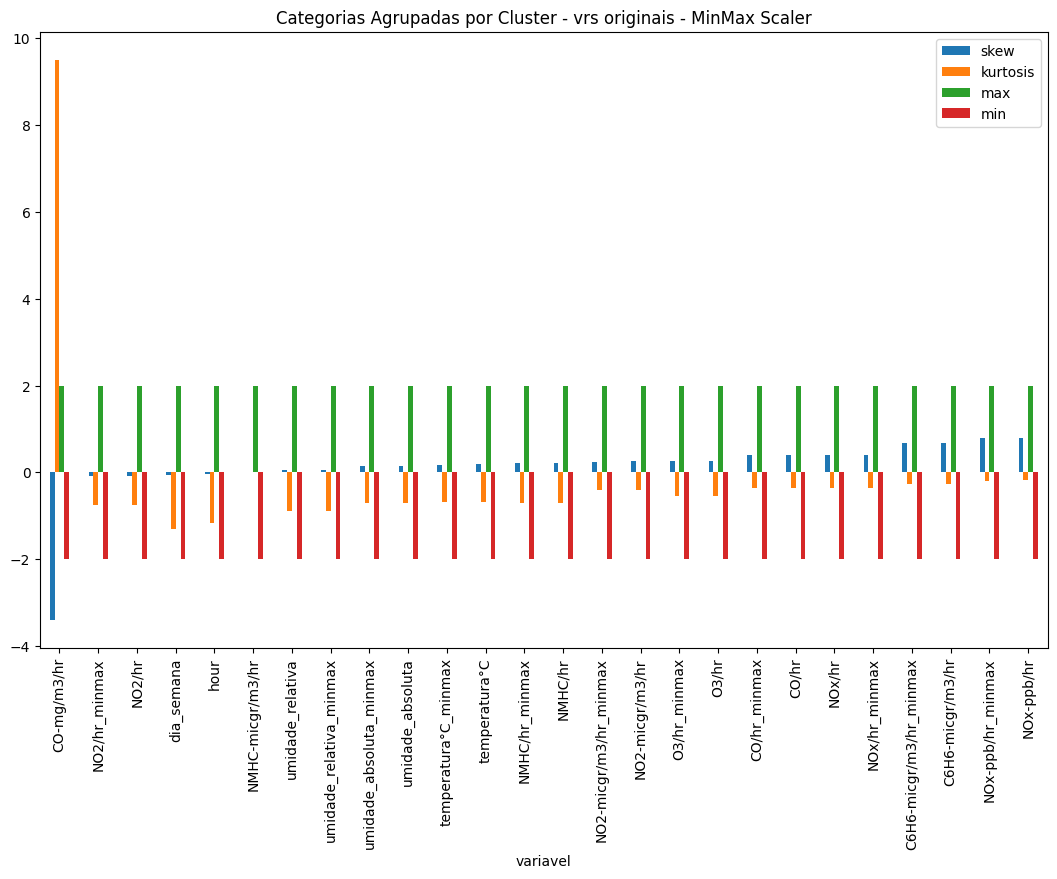

In [143]:
# plotando os valores de skew e kurtosis originais e transformados para comparação
df_skew_kurtosis.plot(x='variavel', 
        kind='bar', 
        stacked=False, 
        title='Categorias Agrupadas por Cluster - vrs originais - MinMax Scaler',
        figsize=(13,8))

Observamos que os valores de skew e kurtosis dos valores originais e dos valores transformados não tem praticamente nenhuma diferença, vamos manter esses valores transformados pois eles podem evitar que ocorra overfitting no treinamento do modelo.

In [144]:
# salva os dados tratados em arquivo csv organizado pelo índice
df_quality_trans.sort_index().to_csv('arquivos_tratados/df_quality_trans.csv', index=False)